## Benchmark Model for crash prediction
### Developed by: bpben
#### Details steps of data processing, feature engineering and model tuning/testing for crash and road data

In [1]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import describe

Helpers for tuning/testing models, available [here](https://github.com/bpben/model_helpers) as well

In [3]:
import sklearn.ensemble as ske
import sklearn.linear_model as skl
from sklearn import metrics
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection as cv

class Indata():
    scoring = None
    data = None
    train_x, train_y, test_x, test_y = None, None, None, None
    is_split = 0
    
    #init with pandas DF and target column name, specify scoring observations
    def __init__(self, data, target, scoring=None):
        #If scoring observations, store under scoring attribute
        if scoring is not None:
            self.data = data[~(scoring)]
            self.scoring = data[scoring]
        else:
            self.data = data
        self.target = target
    
    # Split into train/test
    # pct = percent training observations
    # datesort = specify date column for sorting values
    #   If this is not None, split will be non-random (i.e. split on sorted obs)
    def tr_te_split(self, pct, datesort=None):
        if datesort:
            self.data.sort_values(datesort, inplace=True)
            self.data.reset_index(drop=True, inplace=True)
            inds = np.arange(0.0,len(self.data)) / len(self.data) < pct
        else:
            inds = np.random.rand(len(self.data)) < pct
        self.train_x = self.data[inds]
        print 'Train obs:', len(self.train_x)
        self.train_y = self.data[self.target][inds]
        self.test_x = self.data[~inds]
        print 'Test obs:', len(self.test_x)
        self.test_y = self.data[self.target][~inds]
        self.is_split = 1
        
class Tuner():
    """
    Initiates with indata class, will tune series of models according to parameters.  
    Outputs RandomizedGridCV results and parameterized model in dictionary
    """
    
    data = None
    train_x, train_y = None, None
    
    def __init__(self, indata, best_models=None, grid_results=None):
        if indata.is_split == 0:
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = indata.data
            self.train_x = indata.train_x
            self.train_y = indata.train_y
            if best_models is None:
                self.best_models = {}
            if grid_results is None:
                self.grid_results = pd.DataFrame()
        
            
    def make_grid(self, model, obs, cvparams, mparams):
        #Makes CV grid
        grid = RandomizedSearchCV(
                    model(),scoring=cvparams['pmetric'], 
                    cv = cv.KFold(cvparams['folds']), 
                    refit=False, n_iter=cvparams['iter'],
                    param_distributions=mparams, verbose=1)
        return(grid)
    
    def run_grid(self, grid, train_x, train_y):
        grid.fit(train_x, train_y)
        results = pd.DataFrame(grid.cv_results_)[['mean_test_score','mean_train_score','params']]
        best = {}
        best['bp'] = grid.best_params_
        best[grid.scoring] = grid.best_score_
        return(best, results)
            
    def tune(self, name, m_name, features, cvparams, mparams):
        if hasattr(ske, m_name):
            model = getattr(ske, m_name)
        elif hasattr(skl, m_name):
            model = getattr(skl, m_name)
        else:
            raise ValueError('Model name is invalid.')
        grid = self.make_grid(model, len(self.train_x), cvparams, mparams)
        best, results = self.run_grid(grid, self.train_x[features], self.train_y)
        results['name'] = name
        results['m_name'] = m_name
        self.grid_results = self.grid_results.append(results)
        best['model'] = model(**best['bp'])
        best['features'] = list(features)
        self.best_models.update({name: best}) 
        
class Tester():
    """
    Initiates with indata class, receives parameterized sklearn models, prints and stores results
    """
    
    def __init__(self, data, rundict=None):
        if data.is_split == 0 :
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = data
            if rundict is None:
                self.rundict = {}
            
    #Add tuner object, will populate rundict with names, models, feature
    def init_tuned(self, tuned):
        if tuned.best_models=={}:
            raise ValueError('No tuned models found')
        else:
            self.rundict.update(tuned.best_models)
    
    #Produce predicted class and probabilities
    def predsprobs(self, model, test_x):
        preds = model.predict(test_x)
        probs = model.predict_proba(test_x)[:,1]
        return(preds, probs)
    
    #Produce metrics
    def get_metrics(self, preds, probs, test_y):
        f1_s = metrics.f1_score(test_y, preds)
        brier = metrics.brier_score_loss(test_y, probs)
        auc = metrics.roc_auc_score(test_y, preds)
        c_matrix = metrics.confusion_matrix(test_y, preds)
        return(f1_s, brier, auc, c_matrix)
    
    #Run production, output dictionary
    def make_result(self, model, test_x, test_y):
        preds, probs = self.predsprobs(model, test_x)
        f1_s, brier, auc, c_matrix = self.get_metrics(preds, probs, test_y)
        print "f1_score: ", f1_s
        print "brier_score: ", brier
        print "AUC score: ", auc
        print "Confusion Matrix: ", c_matrix
        result = {}
        #result['preds'] = [int(i) for i in preds]
        #result['probs'] = [float(i) for i in probs]
        result['f1_s'] = f1_s
        result['brier'] = brier
        result['auc'] = auc
        result['c_matrix'] = c_matrix
        return(result)

    # Run model - Specify model, with parameters, features
    # Stores it to rundict, can later be output
    # Will overwrite previous run if name is not different
    def run_model(self, name, model, features, cal=True, cal_m='sigmoid'):
        results = {}
        results['features'] = list(features)
        print "Fitting {} model with {} features".format(name, len(features))
        if cal:
            # Need disjoint calibration/training datasets
            # Split 50/50
            rnd_ind = np.random.rand(len(self.data.train_x)) < .5
            train_x = self.data.train_x[features][rnd_ind]
            train_y = self.data.train_y[rnd_ind]
            cal_x = self.data.train_x[features][~rnd_ind]
            cal_y = self.data.train_y[~rnd_ind]
        else:
            train_x = self.data.train_x[features]
            train_y = self.data.train_y

        m_fit = model.fit(train_x, train_y)
        result = self.make_result(
            m_fit,
            self.data.test_x[features],
            self.data.test_y)

        results['raw'] = result
        results['m_fit'] = m_fit
        if cal:
            print "calibrated:"
            m_c = CalibratedClassifierCV(m_fit, method = cal_m, cv='prefit')
            m_fit_c = m_c.fit(cal_x, cal_y)
            result_c = self.make_result(m_fit_c, self.data.test_x[features], self.data.test_y)
            results['calibrated'] = result_c              
            print "\n"
        if name in self.rundict:
            self.rundict[name].update(results)
        else:
            self.rundict.update({name:results})
    
    #Run from tuned set
    def run_tuned(self, name, cal=True, cal_m='sigmoid'):
        self.run_model(name, self.rundict[name]['model'], self.rundict[name]['features'], cal, cal_m)
    
    #Output rundict to csv
    def to_csv(self):
        if self.rundict == {}:
            raise ValueError('No results found')
        else:
            now = pd.to_datetime('today').value
            #Make dataframe, transpose so each row = model
            pd.DataFrame(self.rundict).T.to_csv('results_{}.csv'.format(now))

### Data processing
The approach here is to create 3 time-lag features:

1. crashes in the past week
2. crashes in the past month
3. crashes in the past quarter (three months)
4. average crashes per week up to target week

All features except 4 are calculated to exclude one another.  That is, crashes in the past month does not include the past week's crashes.  Crashes in the past quarter do not include the past month.

In [4]:
SEG_CHARS = ['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']

In [5]:
# Read in data
data = pd.read_csv('../../data/processed/vz_predict_dataset.csv.gz', compression='gzip', dtype={'segment_id':'str'})
data.sort_values(['segment_id', 'year', 'week'], inplace=True)

In [7]:
# get segments with non-zero crashes
data_nonzero = data.set_index('segment_id').loc[data.groupby('segment_id').crash.sum()>0]
data_nonzero.reset_index(inplace=True)

In [8]:
def format_crash_data(data, col, target_week, target_year):
    """ formats crash data for train/test 
    target_week: week to predict (make into binary target)
    target_year: year for predicted week
    note: data must be available for 4 months prior to target
    gets previous week count, previous month count, previous quarter count, avg per week
    """
    assert target_week>16
    pre_week = target_week - 1
    pre_month = range(pre_week-4, target_week)
    pre_quarter = range(pre_month[0]-12, target_week)
    
    # week interval for each segment
    # full range = pre_quarter : target
    sliced = data.loc[(slice(None),slice(target_year,target_year), slice(1, target_week)),:]
    week_data = sliced[col].unstack(2)
    week_data.reset_index(level=1, inplace=True)
    
    # aggregate
    week_data['pre_month'] = week_data[pre_month].sum(axis=1)
    week_data['pre_quarter'] = week_data[pre_quarter].sum(axis=1)
    week_data['pre_week'] = week_data[pre_week]

    # avg as of target week
    except_target = data.loc[(slice(None),
                       slice(target_year,target_year),
                       slice(target_week,None)),:].index
    avg_week = data.drop(except_target)
    avg_week = avg_week.reset_index().groupby('segment_id')[col].mean()
    avg_week.name = 'avg_week'
    # join to week data
    week_data = week_data.join(avg_week)

    # binarize target
    week_data['target'] = (week_data[target_week]>0).astype(int)
    week_data = week_data.reset_index()

    return(week_data[['segment_id','target', 'pre_week',
                      'pre_month', 'pre_quarter', 'avg_week']])

In [9]:
crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', 19, 2017)

In [10]:
data_segs = data_nonzero.groupby('segment_id')[SEG_CHARS].max()  # grab the highest values from each column for a segment, not used in model?
data_segs.reset_index(inplace=True)

In [81]:
data_model = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')

In [82]:
# Add in adjacency info
adj_info = pd.read_csv('../../data/processed/adjacency_info.csv', usecols=['segment_id', 'orig_id'],
                       dtype={'segment_id':'str', 'orig_id':'str'})

# link adjacent segments for segments with crashes
adj_info = adj_info[adj_info.segment_id.isin(data_model.segment_id)]
adj_mat = adj_info.merge(adj_info, on='orig_id')
adj_mat = adj_mat[['segment_id_x', 'segment_id_y']]
adj_mat.drop_duplicates(inplace=True)
# including segments with only self-adjacent
# for this, need to ensure they don't join to their own data
adj_mat.loc[adj_mat.segment_id_x==adj_mat.segment_id_y, 'segment_id_y'] = np.NaN

def get_adj_crash_lags(target_week, target_year):
    """calculate total number of crashes that occurred 
    in adjacent segments for target week and lags as defined in format_crash_data
    """ 
    lag_data = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', target_week, target_year)
    merge_lags = adj_mat.merge(lag_data, left_on='segment_id_y', right_on='segment_id', how='left')
    adj_lags = merge_lags.groupby(['segment_id_x'])['pre_week', 'pre_month', 'pre_quarter'].sum()
    return adj_lags

adj_lags = get_adj_crash_lags(19, 2017)

In [83]:
# fill those with only self-adj zero
adj_lags.fillna(0, inplace=True)

In [85]:
data_model = data_model.merge(adj_lags, how='left', left_on='segment_id', right_index=True, suffixes=('', '_adj'))
data_model.fillna(0, inplace=True)

In [87]:
# standardize for LR
from sklearn.preprocessing import scale
data_scaled = pd.DataFrame(scale(data_model[features]), 
                          columns=[f+'_scaled' for f in features])
data_model = pd.concat([data_model, data_scaled], axis=1)

### Model tuning
This uses the model helpers above.  They're based on sklearn and implement a randomized grid search with K-fold crossvalidation.

In [89]:
#Initialize data
df = Indata(data_model, 'target')
#Create train/test split
df.tr_te_split(.7)

Train obs: 2367
Test obs: 1011


In [90]:
#Parameters for model
#Model parameters
params = dict()

#cv parameters
cvp = dict()
cvp['pmetric'] = 'roc_auc'
cvp['iter'] = 5 #number of iterations
cvp['folds'] = 5 #folds for cv (default)

#LR parameters
mp = dict()
mp['LogisticRegression'] = dict()
mp['LogisticRegression']['penalty'] = ['l1','l2']
mp['LogisticRegression']['C'] = ss.beta(a=5,b=2) #beta distribution for selecting reg strength
mp['LogisticRegression']['class_weight'] = ['balanced']

#RF model parameters
mp['RandomForestClassifier'] = dict()
mp['RandomForestClassifier']['n_estimators'] = [2**8] #number of trees in the forest
mp['RandomForestClassifier']['max_features'] = ss.beta(a=5,b=2) #number of features at split
mp['RandomForestClassifier']['max_leaf_nodes'] = [100]#ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create
mp['RandomForestClassifier']['class_weight'] = ['balanced']

In [91]:
# Features
features = [u'pre_week', u'pre_month', u'pre_quarter', 'avg_week', u'AADT', u'SPEEDLIMIT',
            u'Struct_Cnd', u'Surface_Tp', u'F_F_Class', u'pre_week_adj', 
            u'pre_month_adj', u'pre_quarter_adj']

In [92]:
#Initialize tuner
tune = Tuner(df)

In [93]:
#Base RF model
tune.tune('RF_base', 'RandomForestClassifier', features, cvp, mp['RandomForestClassifier'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   32.8s finished


In [94]:
#Base LR model
tune.tune('LR_base', 'LogisticRegression', data_scaled.columns.tolist(), cvp, mp['LogisticRegression'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


In [95]:
#Display results
tune.grid_results

,mean_test_score,mean_train_score,params,name,m_name
0,0.635994,0.995868,"{u'max_features': 0.389196245251, u'max_leaf_n...",RF_base,RandomForestClassifier
1,0.651383,0.995638,"{u'max_features': 0.613217094246, u'max_leaf_n...",RF_base,RandomForestClassifier
2,0.632742,0.996014,"{u'max_features': 0.833420505488, u'max_leaf_n...",RF_base,RandomForestClassifier
3,0.654406,0.995925,"{u'max_features': 0.595902600931, u'max_leaf_n...",RF_base,RandomForestClassifier
4,0.631697,0.995871,"{u'max_features': 0.667780932224, u'max_leaf_n...",RF_base,RandomForestClassifier
0,0.645893,0.726176,"{u'penalty': u'l2', u'C': 0.705986815718, u'cl...",LR_base,LogisticRegression
1,0.645853,0.726174,"{u'penalty': u'l1', u'C': 0.586447486838, u'cl...",LR_base,LogisticRegression
2,0.645977,0.726112,"{u'penalty': u'l1', u'C': 0.554174723574, u'cl...",LR_base,LogisticRegression
3,0.645966,0.726531,"{u'penalty': u'l1', u'C': 0.846027150078, u'cl...",LR_base,LogisticRegression
4,0.646151,0.726500,"{u'penalty': u'l1', u'C': 0.88057896213, u'cla...",LR_base,LogisticRegression


In [102]:
# Run test
test = Tester(df)
test.init_tuned(tune)
test.run_tuned('RF_base', cal=False)
test.run_tuned('LR_base', cal=False)

Fitting RF_base model with 12 features
f1_score:  0.0
brier_score:  0.0215573952264
AUC score:  0.494994994995
Confusion Matrix:  [[989  10]
 [ 12   0]]
Fitting LR_base model with 12 features
f1_score:  0.0444444444444
brier_score:  0.203363491209
AUC score:  0.623873873874
Confusion Matrix:  [[747 252]
 [  6   6]]


In [31]:
# Check feature importance
f_importance = tune.best_models['RF_base']['m_fit'].feature_importances_
fi = list(zip(features, f_importance))
print sorted(fi, key=lambda x: x[1], reverse=True)

[(u'AADT', 0.35615405664948058), ('avg_week', 0.2808856808158679), (u'SPEEDLIMIT', 0.12822782182676984), (u'Struct_Cnd', 0.1057143126098706), (u'F_F_Class', 0.045649454090312416), (u'pre_quarter', 0.036436559482359333), (u'Surface_Tp', 0.027628125151329751), (u'pre_month', 0.015104806651960005), (u'pre_week', 0.0041991827220493709)]


### Lift chart by "risk bin"
The classifier problem is difficult because the classes are unbalanced (.05% have crashes at target week).  More useful are the probabilities being produced by the model, which give some idea of risk.

In [97]:
def lift_chart(x_col, y_col, data, ax=None):

    p = sns.barplot(x=x_col, y=y_col, data=data, 
                    palette='Reds', ax = None, ci=None)
    vals = p.get_yticks()
    p.set_yticklabels(['{:3.0f}%'.format(i*100) for i in vals])
    xvals = [x.get_text().split(',')[-1].strip(']') for x in p.get_xticklabels()]
    xvals = ['{:3.0f}%'.format(float(x)*100) for x in xvals]
    p.set_xticklabels(xvals)
    p.set_facecolor('white')
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_title('Predicted probability vs actual percent')
    return(p)
    
def density(data, score, ax=None):
    p = sns.kdeplot(risk_df['risk_score'], ax=ax)
    p.set_facecolor('white')
    p.legend('')
    p.set_xlabel('Predicted probability of crash')
    p.set_title('KDE plot predictions')
    return(p)

In [98]:
risk_scores = test.rundict['LR_base']['m_fit'].predict_proba(test.data.test_x[features])[:,1]
risk_df = pd.DataFrame({'risk_score':risk_scores, 'crash':test.data.test_y})
print risk_df.risk_score.describe()
risk_df['categories'] = pd.cut(risk_df['risk_score'], bins=[-1, 0, .01, .02, .05, max(risk_scores)])
risk_mean = risk_df.groupby('categories')['crash'].count()
print risk_mean

count    1011.000000
mean        0.984928
std         0.052679
min         0.173463
25%         0.986495
50%         1.000000
75%         1.000000
max         1.000000
Name: risk_score, dtype: float64
categories
(-1, 0]            0
(0, 0.01]          0
(0.01, 0.02]       0
(0.02, 0.05]       0
(0.05, 1]       1011
Name: crash, dtype: int64


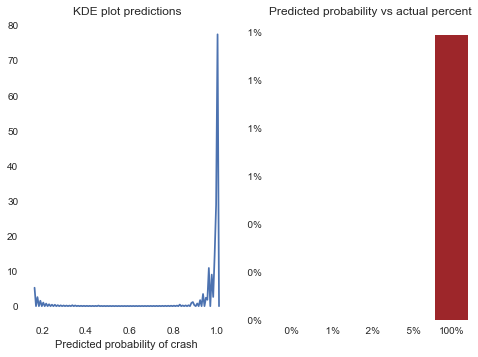

In [99]:
fig, axes = plt.subplots(1, 2)
lift_chart('categories', 'crash', risk_df, 
           ax=axes[1])
density(risk_df, 'risk_score', ax=axes[0])

In [53]:
# output predictions
# predict on all segments
data_model['risk_score'] = test.rundict['RF_base']['m_fit'].predict_proba(data_model[features])[:,1]
data_model.to_csv('seg_with_risk_score_adj.csv', index=False)

### Check sensitivity to week
I predicted an arbitrary week as target here, but I'd like to see whether things change significantly if I change that week.  A good metric to measure that is brier score loss.  It'll be low throughout as the classifier doesn't perform great, but it shouldn't vary a huge amount.

In [100]:
def run_model_for_week(weeks=[20, 30, 40, 50], output=False):
    for w in [20, 30, 40, 50]:
        print "week ", w
        crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', w, 2016)
        data = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')
        adj_lags = get_adj_crash_lags(w, 2016)
        data = data.merge(adj_lags, left_on='segment_id', right_index=True, suffixes=('', '_adj'))
        data.fillna(0, inplace=True)
        df = Indata(data, 'target')
        # create train/test split
        df.tr_te_split(.7)
        test = Tester(df)
        test.init_tuned(tune)
        test.run_tuned('LR_base', cal=False)
        print '\n'
    if output==True:
        return(test.rundict['LR_base']['m_fit'].pred)

In [101]:
run_model_for_week()

week  20
Train obs: 2367
Test obs: 1011
Fitting LR_base model with 12 features


KeyError: "[u'pre_week_scaled' u'pre_month_scaled' u'pre_quarter_scaled'\n 'avg_week_scaled' u'AADT_scaled' u'SPEEDLIMIT_scaled' u'Struct_Cnd_scaled'\n u'Surface_Tp_scaled' u'F_F_Class_scaled' u'pre_week_adj_scaled'\n u'pre_month_adj_scaled' u'pre_quarter_adj_scaled'] not in index"

In [ ]:
# week predictions output
